# Testing isostatic boundary conditions in UW2

This is a check to make sure UW2's pressure boundary condition properly works.

The setup is:

     <--------- 100 km ------------>
    _________________________________
    |                               |  ^
    |                               |  |
    |     compressible air          |  50 km 
    |        1 kg.m^-3              |  |
    |                               |  | 
    |_______________________________|  v 
    |crust    | weaker  |  crust    |  ^ 
    |500 kg.  | crust   |           |  25 km 
    |_________|_________|___________|  v 
    |        mantle                 |  ^ 
    |        1000 kg.m^-3           |  25 km 
    |_______________________________|  v 


In this case we put a weaker blob in the middle of the crust, to see what 
happens with necking occuring

Otherwise, same as before:
If we pull long enough, we expect the crust material to thin to essentially
0 thickness, and that the surface will subside by some amount. 

Analytically, assuming the crust thickness has been thinned to 0, we get this 
formula to calculate the subsidence:

    h = ( rho_crust * a - rho_mantle * a ) / ( rho_air - rho_mantle )

where h is the subsidence amount, and a is the original thickness of the crust layer.

This calculation comes out to ~12.5 km of subsidence. If you run this model, you will
see the approximately same answer! Hooray!

Note: the model does encounter some velocity instabilities, but broadly seems to be correct.
With higher resolution, or smaller timesteps, it might be happier

In [1]:
import underworld as uw
import UWGeodynamics as GEO
import numpy as np
import matplotlib.pyplot as plt

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
GEO.rcParams['solver'] = "mumps"
GEO.rcParams["surface.pressure.normalization"] = True

# must be 0, because we use compressible air
GEO.rcParams["penalty"] = 0

# Use some higher order elements to get a nicer solution
GEO.rcParams["element.type"] = "Q2/dQ1"

# Use the fancier advection diffusion method
GEO.rcParams["advection.diffusion.method"] = "SLCN"

# Normally this is 0.5, but it can make it easier for the solver if you reduce this number.
GEO.rcParams["CFL"] = 0.25

# Adjust how particles populate the model. Because this model has a big load of inflowing material,
# I like to have these very aggressive
GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 60
GEO.rcParams["swarm.particles.per.cell.2D"] = 60

In [3]:
GEO.rcParams["output.directory"] = "simple_isos_1"

In [4]:
# This is all for scaling the model
# most of it is pretty self explanitory, try to make them match your setup as best as possible
half_rate = 1.0 * u.centimeter / u.year
model_length = 100e3 * u.meter
model_height = 100e3 * u.meter
refViscosity = 1e22 * u.pascal * u.second
bodyforce = 500 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [5]:
# Setup the model domain and resolution. The 'divisor' is just an easy way to adjust the resolution
divisor = 4
Model = GEO.Model(elementRes=(int(100/divisor),int(100/divisor)), 
                  minCoord=(-50 * u.kilometer, -50 * u.kilometer),
                  maxCoord=( 50 * u.kilometer,  50 * u.kilometer))

In [6]:
air      = Model.add_material(name="air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
uc       =  Model.add_material(name="crust",  shape=GEO.shapes.Layer2D(top=air.bottom, bottom=-25*u.kilometer))
weakzone =  Model.add_material(name="weak",  shape=GEO.shapes.Box(minX=-12.5*u.kilometer, maxX=12.5*u.kilometer, top=air.bottom, bottom=-25*u.kilometer))
mantle   = Model.add_material(name="mantle",  shape=GEO.shapes.Layer2D(top=uc.bottom, bottom=Model.bottom))

# We use 'easy' numbers here, so the analytical calculation is easier.
air.density       =    1. * u.kilogram / u.metre**3
uc.density        =  500. * u.kilogram / u.metre**3
weakzone.density  =  500. * u.kilogram / u.metre**3
mantle.density    = 1000. * u.kilogram / u.metre**3


air.viscosity      = 1e19 * u.pascal * u.second
uc.viscosity       = 1e21 * u.pascal * u.second
weakzone.viscosity = 2e20 * u.pascal * u.second
mantle.viscosity   = 1e20 * u.pascal * u.second


# we need to make the air compressible, so we can put a no infow boundary condition on the top of the model
air.compressibility = 1e3  # Not sure what's a good value

In [7]:
# We need to initialise the model before calculating anything to serious (like the lithostatic pressure)
Model.init_model()

# This is where isostasy is imposed. We first calculate the lithostatic pressure along the entire bottom of the model. 
P, bottomPress = Model.get_lithostatic_pressureField()

# Then, since the model is laterally homogenous, we average it, and put it into megapascals
bottomPress = GEO.Dimensionalize(np.average(bottomPress), u.megapascal)


# This is where we apply the boundary conditions. As a rule of thumb, the more information we can give to UW, the happier
# it will be. For example, we could make the top a free slip condition:
#     top=[None , 0. * u.centimetre / u.year]
# but really, we don't care much about the top of the air, so giving 'extra info' in the form of a no-slip condition
# helps UW figure out what's going on.
# Try removing various bits of information to compare how the model performs.
Model.set_velocityBCs(left   = [-1.0 * u.centimetre / u.year, 0 * u.centimetre / u.year], 
                      right  = [1.0 * u.centimetre / u.year,  0 * u.centimetre / u.year], 
                      top    = [0 * u.centimetre / u.year,    0. * u.centimetre / u.year], 
                      bottom = [None,                         bottomPress]) # This is where the pressure boundary is applied.

In [8]:
# Here we setup a passive tracer - just one particle, right at the top of the crust, right in the middle of the
# model. Hopefully it won't advect too much in either direction, but really we only care about its height.
mswarm = uw.swarm.Swarm( mesh=Model.mesh, particleEscape=True )
msAdvector= uw.systems.SwarmAdvector(Model.velocityField, mswarm, order=4)

height_through_time = []

particleCoordinates = np.zeros((1,2))
particleCoordinates[:,0] = 0
particleCoordinates[:,1] = 0
_ = mswarm.add_particles_with_coordinates(particleCoordinates)

# Here we have to tell UWGeodynamics that we have some extra work to do at the end of each solve
def advect_passive():
    msAdvector.integrate(Model._dt)
    height_through_time.append((Model.time.magnitude, GEO.Dimensionalize(mswarm.particleCoordinates.data[:,1].copy()[0], u.kilometer).magnitude))
    #mswarm.[:,0] = 0  # reset back to centre - not sure how to do this.
Model.postSolveHook = advect_passive

In [9]:
# This is a bunch of solver options. You can try playing with them, but these should be good enough.
Model.solver = Model.stokes_solver()
Model.solver.options.A11.ksp_rtol=1e-8
Model.solver.options.scr.ksp_rtol=1e-8
Model.solver.options.scr.use_previous_guess = True
Model.solver.options.scr.ksp_set_min_it_converge = 10
Model.solver.options.scr.ksp_type = "cg"
Model.solver.options.main.remove_constant_pressure_null_space=True


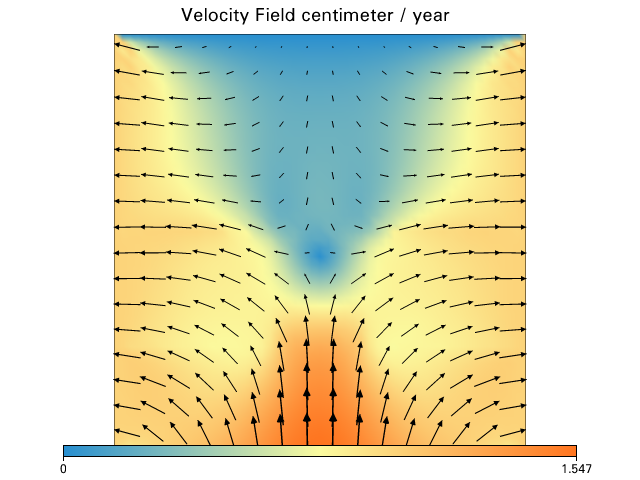


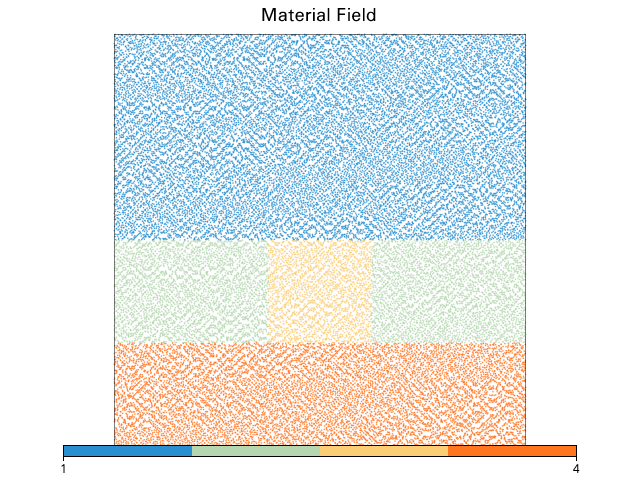

In [10]:
# Do an initial solve to give us a look at what's happening.
Model.solve()
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

## Run model in a few increments, and show the results

In [11]:
Model.run_for(2.5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  16160.087906156608 year dt: 16160.08790615661 year (2018-10-25 05:07:59)
Step:2 Model Time:  35900.96134495959 year dt: 19740.873438802984 year (2018-10-25 05:07:59)
Step:3 Model Time:  56382.09154652328 year dt: 20481.13020156369 year (2018-10-25 05:07:59)
Step:4 Model Time:  74760.16940657362 year dt: 18378.077860050344 year (2018-10-25 05:08:00)
Step:5 Model Time:  94336.77720509714 year dt: 19576.607798523524 year (2018-10-25 05:08:00)
Step:6 Model Time:  115231.11020472395 year dt: 20894.332999626808 year (2018-10-25 05:08:00)
Step:7 Model Time:  136836.28829323495 year dt: 21605.17808851099 year (2018-10-25 05:08:01)
Step:8 Model Time:  160291.58014452987 year dt: 23455.29185129494 year (2018-10-25 05:08:01)
Step:9 Model Time:  183830.1117639095 year dt: 23538.531619379613 year (2018-10-25 05:08:01)
Step:10 Model Time:  208514.5105104637 year dt: 24684.398746554245 year (2018-10-25 05:08:02)
Ste

Step:88 Model Time:  2076533.0539263159 year dt: 24763.52279282854 year (2018-10-25 05:08:28)
Step:89 Model Time:  2101220.0549424803 year dt: 24687.001016164446 year (2018-10-25 05:08:29)
Step:90 Model Time:  2125928.785040078 year dt: 24708.730097597738 year (2018-10-25 05:08:29)
Step:91 Model Time:  2150597.6055162987 year dt: 24668.82047622025 year (2018-10-25 05:08:29)
Step:92 Model Time:  2175317.1805619104 year dt: 24719.575045611877 year (2018-10-25 05:08:30)
Step:93 Model Time:  2200047.843278515 year dt: 24730.662716604635 year (2018-10-25 05:08:30)
Step:94 Model Time:  2224772.004040693 year dt: 24724.160762177875 year (2018-10-25 05:08:30)
Step:95 Model Time:  2249519.674990871 year dt: 24747.670950178108 year (2018-10-25 05:08:31)
Step:96 Model Time:  2274248.901437976 year dt: 24729.226447104633 year (2018-10-25 05:08:31)
Step:97 Model Time:  2298985.732862516 year dt: 24736.831424540163 year (2018-10-25 05:08:32)
Step:98 Model Time:  2323384.566152664 year dt: 24398.8332

1


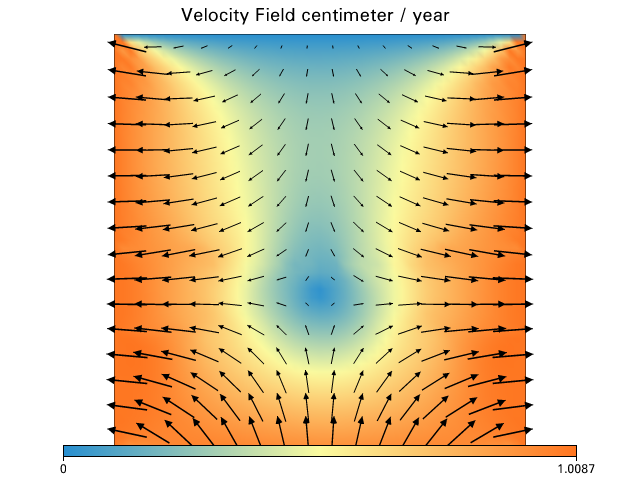


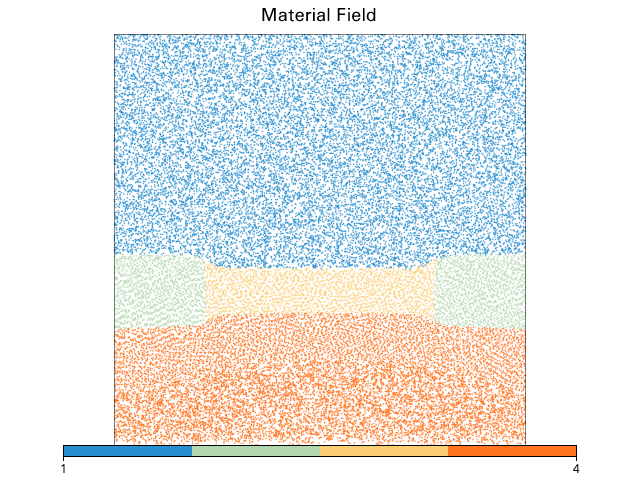

Text(0.5,1,'Subsidence of surface during thinning')

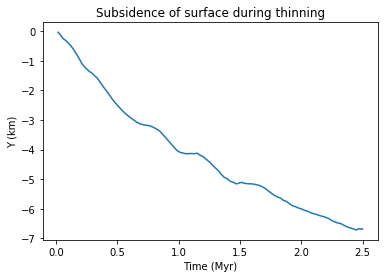

In [12]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [13]:
Model.run_for(2.5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  2524768.39692192 year dt: 24768.396921920878 year (2018-10-25 05:08:37)
Step:2 Model Time:  2549516.12689614 year dt: 24747.729974219823 year (2018-10-25 05:08:37)
Step:3 Model Time:  2574261.829742694 year dt: 24745.702846553904 year (2018-10-25 05:08:38)
Step:4 Model Time:  2599060.6024938757 year dt: 24798.77275118181 year (2018-10-25 05:08:38)
Step:5 Model Time:  2622742.3057214767 year dt: 23681.70322760087 year (2018-10-25 05:08:38)
Step:6 Model Time:  2647516.4799589706 year dt: 24774.1742374942 year (2018-10-25 05:08:39)
Step:7 Model Time:  2671244.6480679205 year dt: 23728.168108949827 year (2018-10-25 05:08:39)
Step:8 Model Time:  2694745.2458847705 year dt: 23500.597816850215 year (2018-10-25 05:08:39)
Step:9 Model Time:  2719525.3386144876 year dt: 24780.092729716944 year (2018-10-25 05:08:40)
Step:10 Model Time:  2744251.5243133744 year dt: 24726.185698886817 year (2018-10-25 05:08:40)
St

Step:88 Model Time:  4593709.567172965 year dt: 17503.95999666723 year (2018-10-25 05:09:07)
Step:89 Model Time:  4618576.321237962 year dt: 24866.754064996327 year (2018-10-25 05:09:08)
Step:90 Model Time:  4638322.27703416 year dt: 19745.95579619785 year (2018-10-25 05:09:08)
Step:91 Model Time:  4663235.635154889 year dt: 24913.3581207289 year (2018-10-25 05:09:08)
Step:92 Model Time:  4682843.008064406 year dt: 19607.372909517177 year (2018-10-25 05:09:09)
Step:93 Model Time:  4707828.66017512 year dt: 24985.652110714287 year (2018-10-25 05:09:09)
Step:94 Model Time:  4731253.6142122755 year dt: 23424.95403715522 year (2018-10-25 05:09:10)
Step:95 Model Time:  4756231.926221121 year dt: 24978.312008845223 year (2018-10-25 05:09:10)
Step:96 Model Time:  4778212.890309461 year dt: 21980.964088340937 year (2018-10-25 05:09:10)
Step:97 Model Time:  4803166.22916593 year dt: 24953.33885646879 year (2018-10-25 05:09:11)
Step:98 Model Time:  4827973.041022149 year dt: 24806.81185621823 ye

1


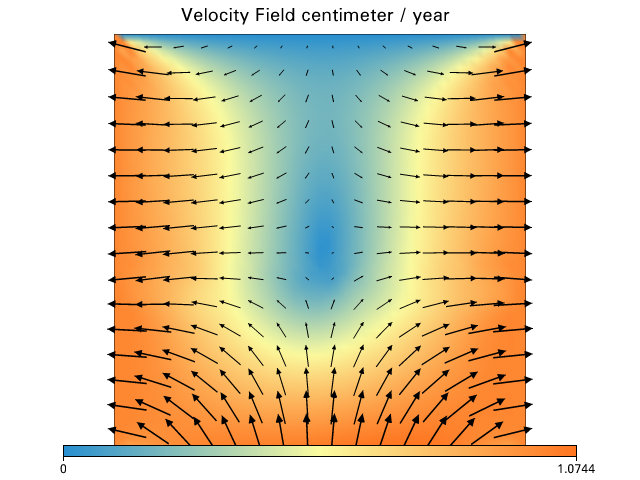


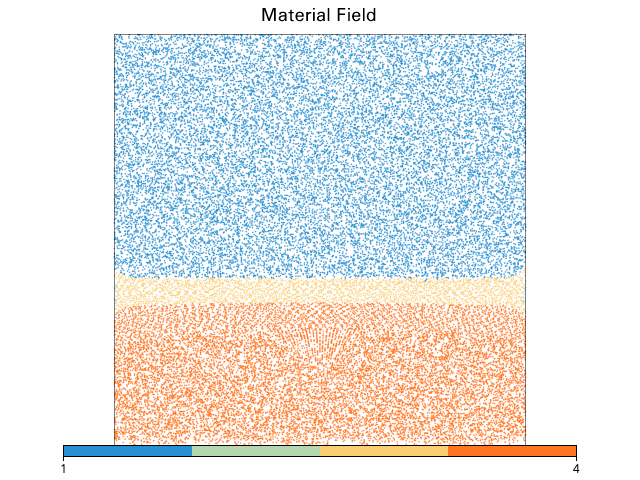

Text(0.5,1,'Subsidence of surface during thinning')

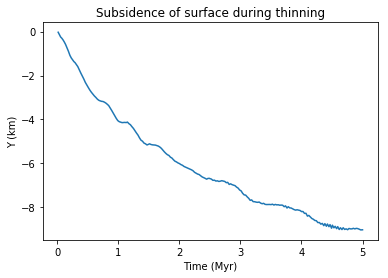

In [14]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [15]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  5023384.770933219 year dt: 23384.770933211923 year (2018-10-25 05:09:16)
Step:2 Model Time:  5048317.359248516 year dt: 24932.58831529693 year (2018-10-25 05:09:17)
Step:3 Model Time:  5066474.8935065 year dt: 18157.534257983807 year (2018-10-25 05:09:17)
Step:4 Model Time:  5091347.747619292 year dt: 24872.854112791458 year (2018-10-25 05:09:17)
Step:5 Model Time:  5109344.535332416 year dt: 17996.787713124573 year (2018-10-25 05:09:18)
Step:6 Model Time:  5134173.04618692 year dt: 24828.510854505195 year (2018-10-25 05:09:18)
Step:7 Model Time:  5154008.800212482 year dt: 19835.754025561724 year (2018-10-25 05:09:18)
Step:8 Model Time:  5178885.121308245 year dt: 24876.32109576205 year (2018-10-25 05:09:19)
Step:9 Model Time:  5199811.49543934 year dt: 20926.374131096432 year (2018-10-25 05:09:19)
Step:10 Model Time:  5224535.951515279 year dt: 24724.456075937716 year (2018-10-25 05:09:19)
Step:11 M

Step:88 Model Time:  7075732.897708046 year dt: 24925.991397111826 year (2018-10-25 05:09:47)
Step:89 Model Time:  7100653.711129548 year dt: 24920.813421501287 year (2018-10-25 05:09:47)
Step:90 Model Time:  7125625.240271679 year dt: 24971.52914213209 year (2018-10-25 05:09:48)
Step:91 Model Time:  7150546.927629297 year dt: 24921.68735761722 year (2018-10-25 05:09:48)
Step:92 Model Time:  7173292.417467641 year dt: 22745.489838344405 year (2018-10-25 05:09:48)
Step:93 Model Time:  7198230.006148424 year dt: 24937.588680782355 year (2018-10-25 05:09:49)
Step:94 Model Time:  7223190.531461678 year dt: 24960.525313254566 year (2018-10-25 05:09:49)
Step:95 Model Time:  7247594.09786777 year dt: 24403.566406092392 year (2018-10-25 05:09:49)
Step:96 Model Time:  7272560.993643806 year dt: 24966.89577603626 year (2018-10-25 05:09:50)
Step:97 Model Time:  7297535.006926224 year dt: 24974.013282417032 year (2018-10-25 05:09:50)
Step:98 Model Time:  7320625.3484277995 year dt: 23090.341501575

Step:175 Model Time:  9135893.003572114 year dt: 24842.922242372402 year (2018-10-25 05:10:17)
Step:176 Model Time:  9160020.514156848 year dt: 24127.5105847345 year (2018-10-25 05:10:17)
Step:177 Model Time:  9184344.793921616 year dt: 24324.279764767118 year (2018-10-25 05:10:18)
Step:178 Model Time:  9208029.96718089 year dt: 23685.173259274048 year (2018-10-25 05:10:18)
Step:179 Model Time:  9233029.967180891 year dt: 24999.999999999884 year (2018-10-25 05:10:18)
Step:180 Model Time:  9251304.518105982 year dt: 18274.55092509193 year (2018-10-25 05:10:19)
Step:181 Model Time:  9276249.736358188 year dt: 24945.218252206323 year (2018-10-25 05:10:19)
Step:182 Model Time:  9295702.066833252 year dt: 19452.330475064133 year (2018-10-25 05:10:19)
Step:183 Model Time:  9320695.314664423 year dt: 24993.247831171706 year (2018-10-25 05:10:20)
Step:184 Model Time:  9339387.674849147 year dt: 18692.360184724217 year (2018-10-25 05:10:20)
Step:185 Model Time:  9364387.674849149 year dt: 24999

1


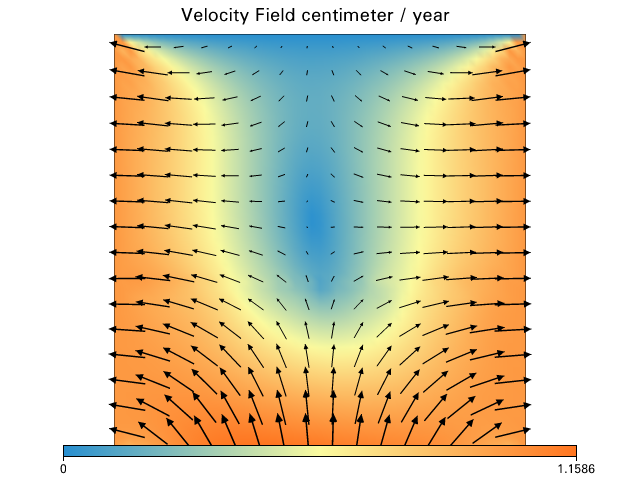


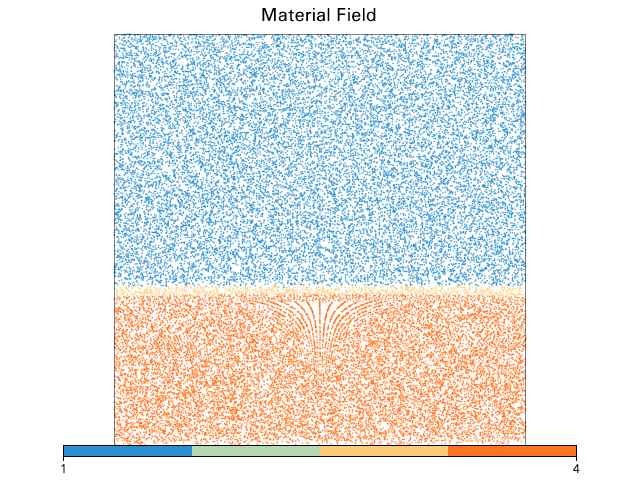

Text(0.5,1,'Subsidence of surface during thinning')

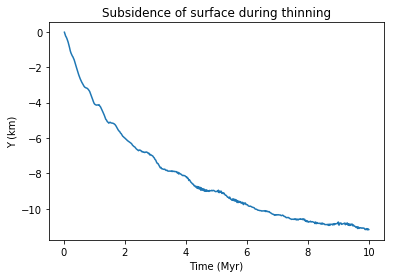

In [16]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [17]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  10024739.415674819 year dt: 24739.41567480133 year (2018-10-25 05:10:33)
Step:2 Model Time:  10049670.923300687 year dt: 24931.507625867594 year (2018-10-25 05:10:33)
Step:3 Model Time:  10074649.8067398 year dt: 24978.883439113495 year (2018-10-25 05:10:33)
Step:4 Model Time:  10096710.176423943 year dt: 22060.36968414194 year (2018-10-25 05:10:34)
Step:5 Model Time:  10121645.1267073 year dt: 24934.950283358023 year (2018-10-25 05:10:34)
Step:6 Model Time:  10145489.645843145 year dt: 23844.519135844115 year (2018-10-25 05:10:34)
Step:7 Model Time:  10170413.171298644 year dt: 24923.52545549933 year (2018-10-25 05:10:35)
Step:8 Model Time:  10194582.238129126 year dt: 24169.066830482592 year (2018-10-25 05:10:35)
Step:9 Model Time:  10219575.20656242 year dt: 24992.968433293572 year (2018-10-25 05:10:35)
Step:10 Model Time:  10238335.18048829 year dt: 18759.973925871644 year (2018-10-25 05:10:36)
St

Step:88 Model Time:  12000168.309258383 year dt: 19210.4444681314 year (2018-10-25 05:11:03)
Step:89 Model Time:  12025124.260486884 year dt: 24955.951228499824 year (2018-10-25 05:11:04)
Step:90 Model Time:  12042537.77498731 year dt: 17413.51450042491 year (2018-10-25 05:11:04)
Step:91 Model Time:  12067475.390061855 year dt: 24937.615074545996 year (2018-10-25 05:11:04)
Step:92 Model Time:  12090361.678109685 year dt: 22886.288047830814 year (2018-10-25 05:11:05)
Step:93 Model Time:  12115306.715623107 year dt: 24945.03751342034 year (2018-10-25 05:11:05)
Step:94 Model Time:  12133713.194405992 year dt: 18406.47878288657 year (2018-10-25 05:11:06)
Step:95 Model Time:  12156625.331757896 year dt: 22912.13735190341 year (2018-10-25 05:11:06)
Step:96 Model Time:  12181625.331757896 year dt: 24999.999999999884 year (2018-10-25 05:11:06)
Step:97 Model Time:  12197145.161369858 year dt: 15519.829611962974 year (2018-10-25 05:11:07)
Step:98 Model Time:  12221552.95103732 year dt: 24407.789

Step:174 Model Time:  13916573.49813826 year dt: 16216.929599372037 year (2018-10-25 05:11:35)
Step:175 Model Time:  13941570.736569637 year dt: 24997.238431379283 year (2018-10-25 05:11:35)
Step:176 Model Time:  13955221.946578834 year dt: 13651.210009197534 year (2018-10-25 05:11:36)
Step:177 Model Time:  13980198.346076686 year dt: 24976.399497851136 year (2018-10-25 05:11:36)
Step:178 Model Time:  13995924.936826263 year dt: 15726.590749578254 year (2018-10-25 05:11:36)
Step:179 Model Time:  14020912.752291983 year dt: 24987.815465719865 year (2018-10-25 05:11:37)
Step:180 Model Time:  14033844.10378855 year dt: 12931.35149656646 year (2018-10-25 05:11:37)
Step:181 Model Time:  14058843.510071643 year dt: 24999.406283094 year (2018-10-25 05:11:37)
Step:182 Model Time:  14077331.18922578 year dt: 18487.67915413661 year (2018-10-25 05:11:38)
Step:183 Model Time:  14102226.168775357 year dt: 24894.97954957852 year (2018-10-25 05:11:38)
Step:184 Model Time:  14127167.950417113 year dt:

1


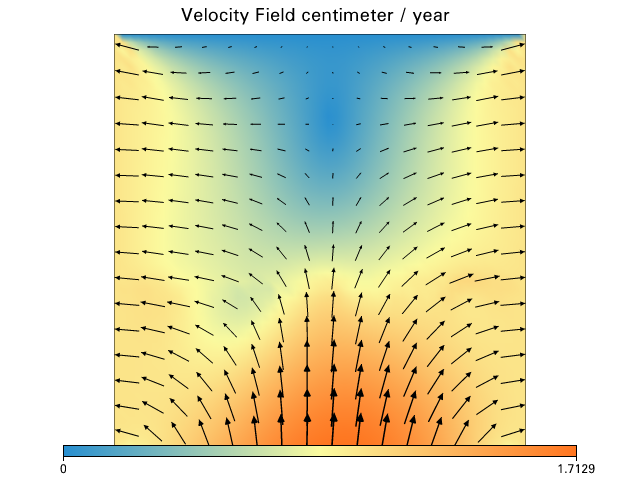


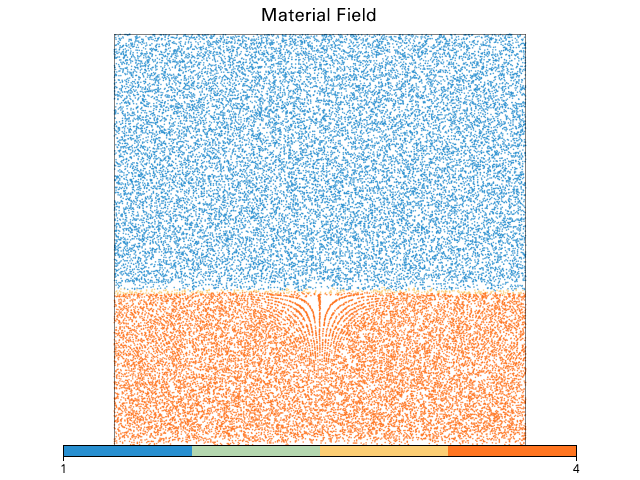

Text(0.5,1,'Subsidence of surface during thinning')

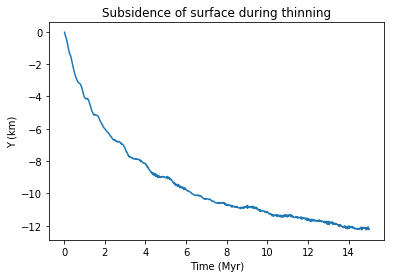

In [18]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

In [19]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  15015963.081585176 year dt: 15963.081585143133 year (2018-10-25 05:11:55)
Step:2 Model Time:  15040818.60943673 year dt: 24855.52785155242 year (2018-10-25 05:11:56)
Step:3 Model Time:  15057067.239989506 year dt: 16248.630552774843 year (2018-10-25 05:11:56)
Step:4 Model Time:  15082067.239989506 year dt: 24999.999999999884 year (2018-10-25 05:11:57)
Step:5 Model Time:  15097478.35071868 year dt: 15411.110729175609 year (2018-10-25 05:11:57)
Step:6 Model Time:  15122420.774915129 year dt: 24942.42419644783 year (2018-10-25 05:11:57)
Step:7 Model Time:  15135686.117595043 year dt: 13265.342679913705 year (2018-10-25 05:11:58)
Step:8 Model Time:  15160659.528006257 year dt: 24973.410411215904 year (2018-10-25 05:11:58)
Step:9 Model Time:  15176017.029862087 year dt: 15357.501855829356 year (2018-10-25 05:11:58)
Step:10 Model Time:  15201017.029862087 year dt: 24999.999999999884 year (2018-10-25 05:11:5

Step:88 Model Time:  16870201.204314582 year dt: 24999.999999999884 year (2018-10-25 05:12:27)
Step:89 Model Time:  16881879.697749987 year dt: 11678.493435403612 year (2018-10-25 05:12:27)
Step:90 Model Time:  16906706.159586202 year dt: 24826.46183621798 year (2018-10-25 05:12:28)
Step:91 Model Time:  16925688.389523882 year dt: 18982.229937677123 year (2018-10-25 05:12:28)
Step:92 Model Time:  16950593.26365112 year dt: 24904.874127242674 year (2018-10-25 05:12:29)
Step:93 Model Time:  16974432.268793568 year dt: 23839.00514244461 year (2018-10-25 05:12:29)
Step:94 Model Time:  16996521.18357326 year dt: 22088.91477969308 year (2018-10-25 05:12:29)
Step:95 Model Time:  17019834.05683443 year dt: 23312.873261170593 year (2018-10-25 05:12:30)
Step:96 Model Time:  17044834.05683443 year dt: 24999.999999999884 year (2018-10-25 05:12:30)
Step:97 Model Time:  17066065.97432627 year dt: 21231.917491841727 year (2018-10-25 05:12:30)
Step:98 Model Time:  17091052.857787993 year dt: 24986.883

Step:175 Model Time:  18744883.326841068 year dt: 24963.040482520748 year (2018-10-25 05:12:59)
Step:176 Model Time:  18760834.66222712 year dt: 15951.335386053323 year (2018-10-25 05:12:59)
Step:177 Model Time:  18785791.58122568 year dt: 24956.918998556845 year (2018-10-25 05:12:59)
Step:178 Model Time:  18808568.157634333 year dt: 22776.57640865544 year (2018-10-25 05:13:00)
Step:179 Model Time:  18833419.597237863 year dt: 24851.439603528717 year (2018-10-25 05:13:00)
Step:180 Model Time:  18849686.299769755 year dt: 16266.702531888934 year (2018-10-25 05:13:00)
Step:181 Model Time:  18874651.336610723 year dt: 24965.03684097195 year (2018-10-25 05:13:01)
Step:182 Model Time:  18894789.521668658 year dt: 20138.185057932136 year (2018-10-25 05:13:01)
Step:183 Model Time:  18919369.648968462 year dt: 24580.12729980632 year (2018-10-25 05:13:01)
Step:184 Model Time:  18941829.236308582 year dt: 22459.587340119422 year (2018-10-25 05:13:02)
Step:185 Model Time:  18966730.07470906 year 

1


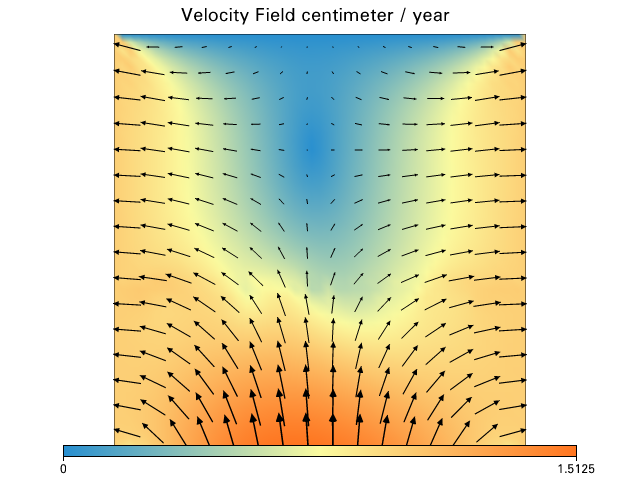


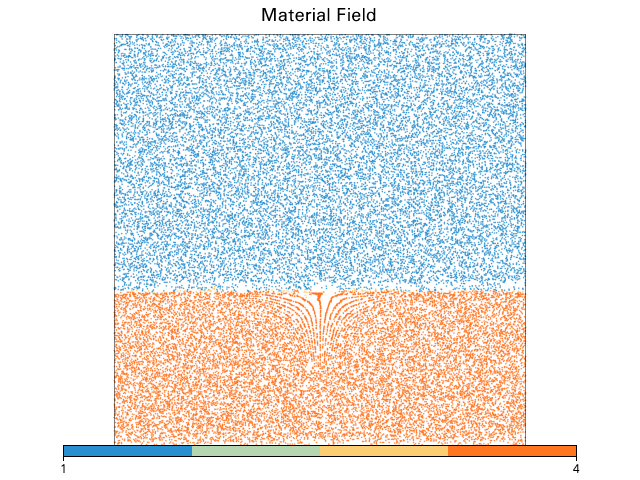

Text(0.5,1,'Subsidence of surface during thinning')

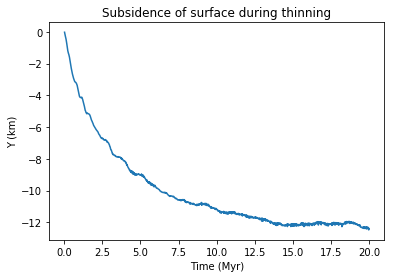

In [20]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])
plt.xlabel("Time (Myr)")
plt.ylabel("Y (km)")
plt.title("Subsidence of surface during thinning")

# Summary

While things get a bit unstable at the end, we can see that the model tends towards the answer we predicted analytically, which is good!

In [21]:
a = uc.bottom - uc.top
expected_subsidence = ( (500 * u.kilogram / u.metre**3) * a - (1000  * u.kilogram / u.metre**3) * a) / ( (1 * u.kilogram / u.metre**3) - (1000 * u.kilogram / u.metre**3) )
print("Expected subsidence: ", expected_subsidence)
print("Modelled subsidence: ", GEO.Dimensionalize(mswarm.particleCoordinates.data[:,1].copy()[0], u.kilometer))
print("The passive tracer also advected laterally from x = 0 to x = {}".format(GEO.Dimensionalize(mswarm.particleCoordinates.data[:,0].copy()[0], u.kilometer)))

Expected subsidence:  -12.512512512512513 kilometer
Modelled subsidence:  -12.389539692552715 kilometer
The passive tracer also advected laterally from x = 0 to x = -7.605045727988699 kilometer
